In [21]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2 as cv
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    InterpolationMode,
)
from matplotlib import pyplot as plt

# HP
folder_name = 'breast40k'
resolution = 512

In this notebbok we will explore the generation of the masks of the bbox.<br>
Half of thw work is already done, as we have both the images and the metadata with the bbox information.<br>

Original coordinates: [3069 2008 3263 2231]
Original size: (4096, 3328)
Reshape size: (512, 512, 3)
Flipped coordinates: [ 259 2008   65 2231]
Resized coordinates: [ 40 309  10 343]
Squared coordinates: [ 40 250  10 284]


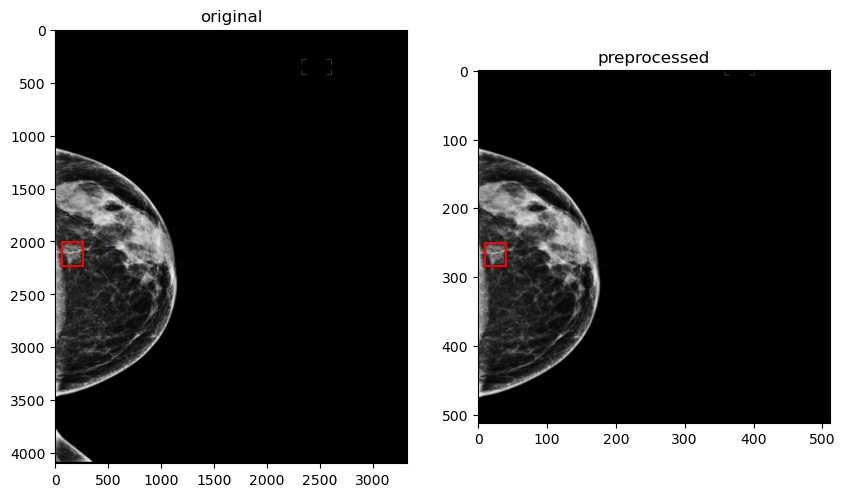

In [24]:
# read metadata file
metadata_path = repo_path / 'data/metadata'/f'lesions_{folder_name}.csv' 
metadata = pd.read_csv(metadata_path)

# example row
i = 100
bbox = metadata.iloc[i]['bbox']
side = metadata.iloc[i]['image_laterality']
# get x1, y1, x2, y2 coordinates form string in that order
bbox = bbox.replace('(', '').replace(')', '').split(',')
x1, y1, x2, y2 = [int(i) for i in bbox]
coord = np.asarray([x1, y1, x2, y2])
print(f'Original coordinates: {coord}')
# add png extension
file_name = metadata.iloc[i].image_id + '.png'
image_path = repo_path / 'data/images/breast40k' / file_name
image_path_RGB = repo_path / 'data/images/breast40k_RGB' / file_name

# read images
im = np.asarray(Image.open(image_path))
im_preprocessed = np.asarray(Image.open(image_path_RGB))

# images sizes
original_size = im.shape
reshape_size = im_preprocessed.shape
print(f'Original size: {original_size}\nReshape size: {reshape_size}')

# if side is right, flip x coordinate
if side == 'R':
    coord[0] =  original_size[1] - coord[0]# -1
    coord[2] =  original_size[1] - coord[2]# -1
    
    print(f'Flipped coordinates: {coord}')

# if any of the coordinates is negative, or the coordinates are zero, skip
if np.any(coord < 0) or (coord[0]-coord[2]) == 0:
    print('Skipping')

# get resized bounding box coordinates
orig_height = original_size[0]
orig_width = original_size[1]
# vector of coordinates
coord_r = (coord * (resolution / orig_width))
coord_r = np.round(coord_r).astype(int) # round to nearest int
print(f'Resized coordinates: {coord_r}')

# get the resized height and width difference beffofe cropping to remove from y coordinates (the larger, height)
resize_diff = int((orig_height * resolution)/orig_width) - resolution
resize_diff = int(resize_diff/2)
# substract from y1 and y2
coord_r[1] = coord_r[1] - resize_diff
coord_r[3] = coord_r[3] - resize_diff
print(f'Squared coordinates: {coord_r}')

# plot original and preprocessed
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('original')
# plot the bbox
ax[0].plot([coord[0], coord[0], coord[2], coord[2], coord[0]], [coord[1], coord[3], coord[3], coord[1], coord[1]], color='r')
ax[1].imshow(im_preprocessed, cmap='gray')
ax[1].set_title('preprocessed')
# plot the bbox
ax[1].plot([coord_r[0], coord_r[0], coord_r[2], coord_r[2], coord_r[0]], [coord_r[1], coord_r[3], coord_r[3], coord_r[1], coord_r[1]], color='r')

Now that the bbox coordinates are available and computed, the next step is to generate the masks.<br>

In [ ]:
# create mask using pil
mask = Image.new('L', (resolution, resolution), 0)